<a href="https://colab.research.google.com/github/sooo19/A-study-of-the-data-generation-model-of-the-Folk-Painting-source-data/blob/main/02_24_FTiger_training_Resnet%2BTransformerDecoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image Caption -> ResNet, TransformerDecoder


https://www.kaggle.com/dipanjandas96/image-caption-resnet-transformerdecoder-pytorch

1. Creating features for Images Using Resnet

2. Train Trnasformer Decoder Model which predicts next word given a sequence of tockens and Image Features from Step1

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import torchvision
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import pickle
import gc
import random

pd.set_option('display.max_colwidth', None)

In [ ]:
# read data
# "/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/archive/Images"
# "/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/archive/captions.txt",

df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/Image_Captioning/captioning_folk_dataset/caption.txt', sep=',')
print(len(df))
display(df.head(3)) # 데이터가 제대로 읽어와졌는지 확인하기 위해, 상위 3개 caption 출력.
display(df.tail(3))


280


,image,caption
0,TMP00001.jpg,Categories: Painting of Tiger Magpie and Pine Tree .
1,TMP00001.jpg,Small Categories: .
2,TMP00001.jpg,Keyword1: tiger .


,image,caption
277,TMP00054.jpg,Keyword1: tiger .
278,TMP00054.jpg,Keyword2: magpie .
279,TMP00054.jpg,Keyword3: pine tree .


#데이터 전처리
Single Character(단일 문자), non alpha word 제거, 토큰과 ',' 추가.
모든 캡션의 최대 길이(max_seq_len)는 33으로 맞춰진다.


In [ ]:
def remove_single_char_word(word_list):
  lst=[]
  for word in word_list:
    if len(word)>1:
      lst.append(word)
  return lst

In [ ]:
# <start> < > < > ... < > <end> 형태로 캡션 저장 => 최대 길이: 17
df['cleaned_caption']=df['caption'].apply(lambda caption : ['<start>']+[word.lower() if word.isalpha() else '' for word in caption.split(" ")]+['<end>'])

# single character 제거
df['cleaned_caption']=df['cleaned_caption'].apply(lambda x:remove_single_char_word(x))

# seq_len에 길이 저장 => 15
df['seq_len']=df['cleaned_caption'].apply(lambda x:len(x))
max_seq_len=df['seq_len'].max()
print(max_seq_len)

15


In [ ]:
df.drop(['seq_len'], axis = 1, inplace=True)
df['cleaned_caption']=df['cleaned_caption'].apply(lambda caption: caption+['<pad>']*(max_seq_len-len(caption)))

# 상위 3개 데이터 예시 출력
display(df.head(3))

,image,caption,cleaned_caption
0,TMP00001.jpg,Categories: Painting of Tiger Magpie and Pine Tree .,"[<start>, painting, of, tiger, magpie, and, pine, tree, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
1,TMP00001.jpg,Small Categories: .,"[<start>, small, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
2,TMP00001.jpg,Keyword1: tiger .,"[<start>, tiger, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"


# Create Vocab and mapping of token to ID

In [ ]:
word_list=df['cleaned_caption'].apply(lambda x: " ".join(x)).str.cat(sep=' ').split(' ')  
#join: , cat(concat): 문자열 합치기. sep=' '에 의해 한 칸씩 뛰고 저장이 된다.
word_dict=Counter(word_list)
word_dict=sorted(word_dict, key=word_dict.get, reverse=True)

print(len(word_dict))
print(word_dict[:20])

34
['<pad>', '<start>', '<end>', 'tiger', 'pine', 'tree', 'magpie', 'and', 'of', 'painting', 'small', 'picture', 'rabit', 'depicting', 'that', 'delivers', 'good', 'news', 'defeats', 'evil']


In [ ]:
vocab_size=len(word_dict)
print(vocab_size)

index_to_word = {index: word for index, word in enumerate(word_dict)} #enumerate: 반복문에서 index값(몇번째 요소인지)을 출력
word_to_index = {word: index for index, word in enumerate(word_dict)}
print(len(index_to_word), len(word_to_index))

34
34 34


# Convert sequence of tokens to IDs

text_seq를 부여함. 단어별로 ID를 부여함.

In [ ]:
df['text_seq']=df['cleaned_caption'].apply(lambda caption: [word_to_index[word] for word in caption])
display(df.head(3))

,image,caption,cleaned_caption,text_seq
0,TMP00001.jpg,Categories: Painting of Tiger Magpie and Pine Tree .,"[<start>, painting, of, tiger, magpie, and, pine, tree, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 9, 8, 3, 6, 7, 4, 5, 2, 0, 0, 0, 0, 0, 0]"
1,TMP00001.jpg,Small Categories: .,"[<start>, small, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 10, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,TMP00001.jpg,Keyword1: tiger .,"[<start>, tiger, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


# Split in Train and validation data. 
(Train과 validation data 나누기) 
한 데이터가 동시에 training, validation data가 될 수 없음.

In [ ]:
df=df.sort_values(by='image')
train=df.iloc[:int(1.0*len(df))]  # train과 validation의 비율은 10:1
valid=df.iloc[int(0.0*len(df)):]

print(len(train), train['image'].nunique()) #nunique() : 데이터에 고유값들의 수를 출력, 즉 중복되는 않은 순 단어의 개수 세기
print(len(valid), valid['image'].nunique())

280 54
280 54


# Extract features from Images Using Resnet
Restnet 구조를 통해 feature 추출

In [ ]:
train_samples=len(train)
print(train_samples)  # train 길이 출력

unq_train_imgs=train[['image']].drop_duplicates() #중복되는 이미지 제거
unq_valid_imgs = valid[['image']].drop_duplicates()
print(len(unq_train_imgs), len(unq_valid_imgs))

280
54 54


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) #Cuda 사용

cuda


In [ ]:
class extractImageFeatureResNetDataSet(): # Resnet 구조를 이용해 이미지의 feature 값들을 추출
  def __init__(self, data):
    self.data=data
    self.scaler=transforms.Resize([224, 224]) # 이미지 크기 재정의
    self.normalize=transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    self.to_tensor=transforms.ToTensor()

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image_name=self.data.iloc[idx]['image']
    img_loc="/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/Image_Captioning/captioning_folk_dataset/images/" + str(image_name)
    img=Image.open(img_loc)
    t_img=self.normalize(self.to_tensor(self.scaler(img)))
    return image_name, t_img

In [ ]:
from torchvision import transforms

In [ ]:
train_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_train_imgs)  # train 이미지들의 feature를 추출해 저장
train_ImageDataloader_ResNet = DataLoader(train_ImageDataset_ResNet, batch_size=1, shuffle=False)

valid_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_valid_imgs)  # validation 이미지들의 feature를 추출해 저장
valid_ImageDataloader_ResNet = DataLoader(valid_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
resnet18.eval()
list(resnet18._modules)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [ ]:
resNet18Layer4 = resnet18._modules.get('layer4').to(device)

In [ ]:
def get_vector(t_img):
  t_img = Variable(t_img)
  my_embedding = torch.zeros(1, 512, 7, 7)  # torch.zeros : 0으로 채워진 텐서 생성
  def copy_data(m, i, o):
    my_embedding.copy_(o.data)

  h = resNet18Layer4.register_forward_hook(copy_data)
  resnet18(t_img)

  h.remove()
  return my_embedding

In [ ]:
#print("/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/archive/Images/1000268201_693b08cb0e.jpg")

In [ ]:
extract_imgFtr_ResNet_train = {}  # train 이미지들의 feature 추출
for image_name, t_img in tqdm(train_ImageDataloader_ResNet):   # tqdm: 진행률 프로그래스바
  t_img = t_img.to(device)
  embdg = get_vector(t_img)

  extract_imgFtr_ResNet_train[image_name[0]] = embdg

  0%|          | 0/54 [00:00<?, ?it/s]

In [ ]:
a_file = open("./EncodedImageTrainResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_train, a_file)
a_file.close()

In [ ]:
#t_image = Image.open(image_name).convert('RGB')

In [ ]:
extract_imgFtr_ResNet_valid = {}
for image_name, t_img in tqdm(valid_ImageDataloader_ResNet):
  t_img = t_img.to(device)
  embdg = get_vector(t_img)
  extract_imgFtr_ResNet_valid[image_name[0]] = embdg

  0%|          | 0/54 [00:00<?, ?it/s]

In [ ]:
a_file=open("./EncodedImageValidResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_valid, a_file)
a_file.close()

#Create DataLoader which will be used to load data into Transformer Model
Transformer 모델에 데이터를 load하는데 사용할 dataloader을 생성

(FlickerDataSetResnet will return caption sequence, 1 timestep left shifted caption sequence which model will predict and Stored Image features from ResNet.)

In [ ]:
global image_tensor_view

class FlickerDataSetResnet():
  def __init__(self, data, pkl_file):
    self.data=data
    self.encodedImgs = pd.read_pickle(pkl_file)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    caption_seq = self.data.iloc[idx]['text_seq']
    target_seq = caption_seq[1:]+[0]

    image_name = self.data.iloc[idx]['image']
    image_tensor = self.encodedImgs[image_name]
    image_tensor = image_tensor.permute(0,2,3,1)  # tensor의 모양을 변환. permute는 모든 차원을 교환할 수 있음.
    image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))
    return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [ ]:
train_dataset_resnet = FlickerDataSetResnet(train, 'EncodedImageTrainResNet.pkl')
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size = 32, shuffle=True)

In [ ]:
valid_dataset_resnet = FlickerDataSetResnet(valid, 'EncodedImageValidResNet.pkl')
valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size = 32, shuffle = True)

#Create Transformer Decoder Model
This model will take caption sequence and the extracted resnet image features as input and output 1 timestep shifted caption sequence.

In the Transformer decoder, lookAhead and padding mask has also been applied

In [ ]:
# Position Embedding

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        

    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]
        
        x = x + self.pe
        return self.dropout(x)

In [ ]:
# Image Captioning Model
# Transformer Decoder

class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.permute(1,0,2)
        

        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)
        
        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)
        

        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)
        

        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)
        
        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask

#Train the Model

The cross entropy loss has been masked at time steps where input token is <'pad'>.

In [ ]:
EPOCH = 1000
#EPOCH = 150

In [ ]:
ictModel = ImageCaptionModel(16, 4, vocab_size, 512).to(device)
optimizer = torch.optim.Adam(ictModel.parameters(), lr = 0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=2, verbose=True)
criterion=torch.nn.CrossEntropyLoss(reduction='none')
min_val_loss=np.float('Inf')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [ ]:
for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    ictModel.train()

    ### Train Loop
    for caption_seq, target_seq, image_embed in train_dataloader_resnet:
        optimizer.zero_grad()

        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)

        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)

        loss = criterion(output,target_seq)

        loss_masked = torch.mul(loss, padding_mask)

        final_batch_loss = torch.sum(loss_masked)/torch.sum(padding_mask)

        final_batch_loss.backward()
        optimizer.step()
        total_epoch_train_loss += torch.sum(loss_masked).detach().item()
        total_train_words += torch.sum(padding_mask)

 
    total_epoch_train_loss = total_epoch_train_loss/total_train_words
  

    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in valid_dataloader_resnet:

            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            loss = criterion(output,target_seq)

            loss_masked = torch.mul(loss, padding_mask)

            total_epoch_valid_loss += torch.sum(loss_masked).detach().item()
            total_valid_words += torch.sum(padding_mask)

    total_epoch_valid_loss = total_epoch_valid_loss/total_valid_words
  
    print("Epoch -> ", epoch," Training Loss -> ", total_epoch_train_loss.item(), "Eval Loss -> ", total_epoch_valid_loss.item() )
  
    if min_val_loss > total_epoch_valid_loss:
        print("Writing Model at epoch ", epoch)
        torch.save(ictModel, './BestModel')
        min_val_loss = total_epoch_valid_loss
  

    scheduler.step(total_epoch_valid_loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch ->  0  Training Loss ->  3.2754852771759033 Eval Loss ->  2.539815664291382
Writing Model at epoch  0
Epoch ->  1  Training Loss ->  2.34946608543396 Eval Loss ->  1.9622609615325928
Writing Model at epoch  1
Epoch ->  2  Training Loss ->  1.926021695137024 Eval Loss ->  1.6084953546524048
Writing Model at epoch  2
Epoch ->  3  Training Loss ->  1.6281136274337769 Eval Loss ->  1.3322510719299316
Writing Model at epoch  3
Epoch ->  4  Training Loss ->  1.3802675008773804 Eval Loss ->  1.0964311361312866
Writing Model at epoch  4
Epoch ->  5  Training Loss ->  1.165485143661499 Eval Loss ->  0.9210129380226135
Writing Model at epoch  5
Epoch ->  6  Training Loss ->  0.9955831170082092 Eval Loss ->  0.8129763007164001
Writing Model at epoch  6
Epoch ->  7  Training Loss ->  0.8818196058273315 Eval Loss ->  0.751773476600647
Writing Model at epoch  7
Epoch ->  8  Training Loss ->  0.8230302929878235 Eval Loss ->  0.7088453769683838
Writing Model at epoch  8
Epoch ->  9  Training Los

#Generate Captions

In [ ]:
model = torch.load('./BestModel')
start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']
max_seq_len = 15  # 캡션의 max length
print(start_token, end_token, pad_token)

1 2 0


In [ ]:
valid_img_embed = pd.read_pickle('EncodedImageValidResNet.pkl')

In [ ]:
def generate_caption(K, img_nm): 
    img_loc = '/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/newHOJAK/images/'+str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)

    model.eval() 
    valid_img_df = valid[valid['image']==img_nm]
    print("Actual Caption : ")
    print(valid_img_df['caption'].tolist())
    img_embed = valid_img_embed[img_nm].to(device)


    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))


    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = index_to_word[next_word_index]

            input_seq[:, eval_iter+1] = next_word_index


            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
    print("\n")
    print("Predicted caption : ")
    print(" ".join(predicted_sentence+['.']))

#Test print (Tiger folk paintings)
호랑이 민화 10장(t1.jpg~t10.jpg)에 대한 예측 캡션 생성

Actual Caption : 
['Keyword3: pine tree .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .']


Predicted caption : 
small .


Actual Caption : 
['Keyword3: pine tree .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .']


Predicted caption : 
small .


Actual Caption : 
['Keyword3: pine tree .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .']


Predicted caption : 
small .


Actual Caption : 
['Keyword3: pine tree .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .']


Predicted caption : 
small .


Actual Caption : 
['Keyword3: pine tree .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .']


Predicted caption : 
small .


Actua

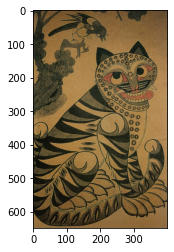

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[1]['image'])
  print("\n")

Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: .', 'Keyword3: .']


Predicted caption : 
.


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: .', 'Keyword3: .']


Predicted caption : 
.


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: .', 'Keyword3: .']


Predicted caption : 
.


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: .', 'Keyword3: .']


Predicted caption : 
.


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: .', 'Keyword3: .']


Predicted caption : 
.


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', '

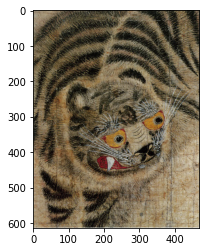

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[2]['image'])
  print("\n")

Actual Caption : 
['Keyword3: pine tree .', 'Keyword2: magpie .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .']


Predicted caption : 
small .


Actual Caption : 
['Keyword3: pine tree .', 'Keyword2: magpie .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .']


Predicted caption : 
small .


Actual Caption : 
['Keyword3: pine tree .', 'Keyword2: magpie .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .']


Predicted caption : 
small .


Actual Caption : 
['Keyword3: pine tree .', 'Keyword2: magpie .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .']


Predicted caption : 
small .


Actual Caption : 
['Keyword3: pine tree .', 'Keyword2: magpie .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .']


Predicted caption : 
small .


Actua

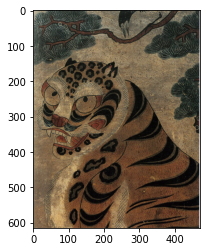

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[3]['image'])
  print("\n")

Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Keyword3: pine tree .']


Predicted caption : 
small .


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Keyword3: pine tree .']


Predicted caption : 
small .


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Keyword3: pine tree .']


Predicted caption : 
small .


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Keyword3: pine tree .']


Predicted caption : 
small .


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Keyword3: pine tree .']


Predicted caption : 
small .


Actua

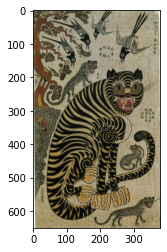

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[5]['image'])
  print("\n")

Actual Caption : 
['Keyword3: pine tree .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .']


Predicted caption : 
pine tree .


Actual Caption : 
['Keyword3: pine tree .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .']


Predicted caption : 
pine tree .


Actual Caption : 
['Keyword3: pine tree .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .']


Predicted caption : 
pine tree .


Actual Caption : 
['Keyword3: pine tree .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .']


Predicted caption : 
pine tree .


Actual Caption : 
['Keyword3: pine tree .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .']


Predicted caption : 

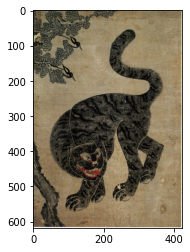

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[6]['image'])
  print("\n")

Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Keyword3: pine tree .']


Predicted caption : 
pine tree .


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Keyword3: pine tree .']


Predicted caption : 
pine tree .


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Keyword3: pine tree .']


Predicted caption : 
pine tree .


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Keyword3: pine tree .']


Predicted caption : 
pine tree .


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Keyword3: pine tree .']


Predicted caption : 

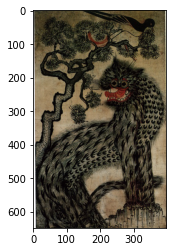

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[7]['image'])
  print("\n")

Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Keyword3: pine tree .']


Predicted caption : 
small .


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Keyword3: pine tree .']


Predicted caption : 
small .


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Keyword3: pine tree .']


Predicted caption : 
small .


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Keyword3: pine tree .']


Predicted caption : 
small .


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Keyword3: pine tree .']


Predicted caption : 
small .


Actua

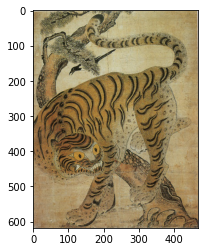

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[8]['image'])
  print("\n")

Actual Caption : 
['Keyword3: pine tree .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .']


Predicted caption : 
small .


Actual Caption : 
['Keyword3: pine tree .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .']


Predicted caption : 
small .


Actual Caption : 
['Keyword3: pine tree .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .']


Predicted caption : 
small .


Actual Caption : 
['Keyword3: pine tree .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .']


Predicted caption : 
small .


Actual Caption : 
['Keyword3: pine tree .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .']


Predicted caption : 
small .


Actua

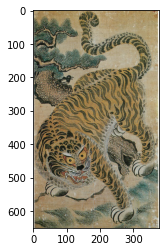

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[9]['image'])
  print("\n")

Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Keyword3: pine tree .']


Predicted caption : 
painting of tiger magpie and pine tree .


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Keyword3: pine tree .']


Predicted caption : 
painting of tiger magpie and pine tree .


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Keyword3: pine tree .']


Predicted caption : 
painting of tiger magpie and pine tree .


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Keyword3: pine tree .']


Predicted caption : 
painting of tiger magpie and pine tree .


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .

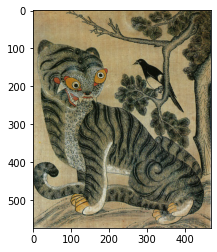

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[10]['image'])
  print("\n")

Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Keyword3: pine tree .']


Predicted caption : 
pine tree .


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Keyword3: pine tree .']


Predicted caption : 
pine tree .


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Keyword3: pine tree .']


Predicted caption : 
pine tree .


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Keyword3: pine tree .']


Predicted caption : 
pine tree .


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: magpie .', 'Keyword3: pine tree .']


Predicted caption : 

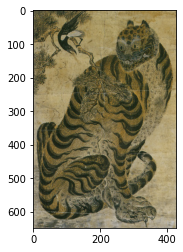

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[15]['image'])
  print("\n")

Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: pine tree .', 'Keyword3: .']


Predicted caption : 
small .


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: pine tree .', 'Keyword3: .']


Predicted caption : 
small .


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: pine tree .', 'Keyword3: .']


Predicted caption : 
small .


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: pine tree .', 'Keyword3: .']


Predicted caption : 
small .


Actual Caption : 
['Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword2: pine tree .', 'Keyword3: .']


Predicted caption : 
small .


Actual Caption : 
['Categories: Painting

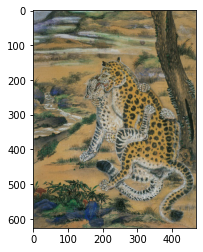

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[20]['image'])
  print("\n")

Actual Caption : 
['Keyword2: rabit .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword3: pine tree .']


Predicted caption : 
small .


Actual Caption : 
['Keyword2: rabit .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword3: pine tree .']


Predicted caption : 
small .


Actual Caption : 
['Keyword2: rabit .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword3: pine tree .']


Predicted caption : 
small .


Actual Caption : 
['Keyword2: rabit .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword3: pine tree .']


Predicted caption : 
small .


Actual Caption : 
['Keyword2: rabit .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .', 'Keyword3: pine tree .']


Predicted caption : 
small .


Actual Cap

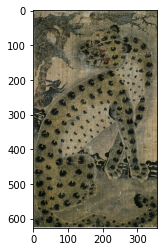

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[25]['image'])
  print("\n")

Actual Caption : 
['Keyword3: pine tree .', 'Keyword2: magpie .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .']


Predicted caption : 
magpie .


Actual Caption : 
['Keyword3: pine tree .', 'Keyword2: magpie .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .']


Predicted caption : 
magpie .


Actual Caption : 
['Keyword3: pine tree .', 'Keyword2: magpie .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .']


Predicted caption : 
magpie .


Actual Caption : 
['Keyword3: pine tree .', 'Keyword2: magpie .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .']


Predicted caption : 
magpie .


Actual Caption : 
['Keyword3: pine tree .', 'Keyword2: magpie .', 'Categories: Painting of Tiger Magpie and Pine Tree .', 'Small Categories: .', 'Keyword1: tiger .']


Predicted caption : 
magpie .




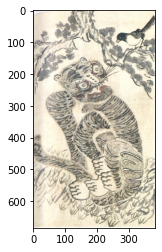

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[30]['image'])
  print("\n")